# Kschool TFM

## Prelude

The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

## Necessary imports

In [1]:
from Spark import InitSpark

In [2]:
import Resources as resources

In [ ]:
import Utilities as utils

In [3]:
import pandas as pd

In [4]:
from matplotlib import pyplot as plt

In [5]:
from pyspark.sql.functions import *

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import Correlation

In [7]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, make_scorer, recall_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier

In [8]:
import warnings

warnings.filterwarnings("ignore")

## Process Code

In [9]:
%matplotlib inline

In [10]:
## basic configuration

ignore = False # If True, process will ignore fields marked as NA in README.md

score_dict = {
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'auc' : make_scorer(roc_auc_score)
} # Scores for cross validation searches

classifier_dict = {
    'dtc': DecisionTreeClassifier,
    'rfc': RandomForestClassifier,
    'gbc': GradientBoostingClassifier,
    'xgb': XGBClassifier    
} # Classifiers for cross validation searches

param_grid_dict = {
    'dtc' = {
        'max_depth': range(1,10), 
    },
    'rfc' = {
        'max_depth': [2, 3, 5, 8, 10, 13, 18],
        'n_estimators': [10, 25, 50, 100]
    },
    'gbc' = {
        'max_depth': [2, 3, 5, 8, 10, 13, 18],
        'n_estimators': [10, 25, 50, 100]
    },
    'xgb' = {
        'max_depth': [2, 3, 5, 8, 10, 13, 18],
        'n_estimators': [10, 25, 50, 100]
    }    
} # Param grids for cross validation searches

score_refit = 'recall' # The cross validation searches will be refitted against this score. It should be in score_dict
schema = resources.df_schema2 # Schema from Resources.py for our model
cv = 5 # Loops in data for cross validation searches
n_iter = 30 # Number of parameter settings that are sampled in RandomizedSearchCV

0: Not ignore NA fields
Other: Ignore NA fields
Enter a number: 0


In [11]:
initSpark = InitSpark()

In [12]:
spark = initSpark.getSparkSession()

In [13]:
spark

In [14]:
options = {'header': 'true', 'delimiter': ','}

In [15]:
train_df = spark.read.options(**options).schema(df_schema2).csv(train_path) #schema(df_schema).

In [16]:
types = {field.name: field.dataType for field in train_df.schema.fields}

```
train_df.groupBy(col('HasDetections')).agg(count(lit(1))).show()

+-------------+--------+
|HasDetections|count(1)|
+-------------+--------+
|            1| 4458892|
|            0| 4462591|
+-------------+--------+
```

**fields**: Contains all column names in the df

**in_model**: Contains all column name in the df that we are going to use in our model. All True this point.

**target**: Conatins target column name

In [17]:
fields = [field.name for field in df_schema.fields]
in_model = {field: True for field in fields[1:-1]} 
target = fields[-1]
column_id = fields[0]

In [18]:
# test_df = spark.read.options(**options).schema(df_schema).csv(test_path).drop(target)

The below variable could be loaded directly from ***Resources***. We only executed it once to avoid expensing so many time in it.

In [19]:
# different_values = {k: train_df.select(k).distinct().count() for k in in_model.keys()}    

Now, with **different_values** calculated, we are gonna decide which columns to use as input of our model.

In [20]:
columns = pd.DataFrame.from_dict(different_values, orient='index', columns=['how_many'])

In [21]:
columns.describe()

,how_many
count,8.200000e+01
mean,1.207026e+05
std,9.859126e+05
min,2.000000e+00
25%,3.000000e+00
50%,1.350000e+01
75%,2.910000e+02
max,8.921483e+06


As we can see, a percentage of columns between 50 and 75 percent has no more than 100 different values, so, we are gonna update **in_model** to take only columns with less than 100 different values.

In [22]:
in_model = {k: True if (different_values[k] <= 100) else False for k in in_model.keys()}

We are gonna also exclude those fields which are marked as NA in the README.md

In [23]:
with open('README.md', 'r') as f:
    text = f.read().split('\n')
    na_fields = [line.split()[1] for line in text if line.endswith("NA")]        

In [24]:
in_model = {k: False if k in na_fields else in_model[k] for k in in_model.keys()}

In [25]:
select_fields = [k for k in in_model.keys() if in_model[k]]

In [ ]:
small_train_df = train_df.select(*select_fields, target).sample(.1)

In [ ]:
# small_test_df = test_df.select(*select_fields).sample(.01)

Checking if **target** is still pondered

In [ ]:
small_train_df.groupBy(col(target)).agg(count(lit(1))).show()

In [ ]:
for field in select_fields:
    if (types[field] == StringType()):
        small_train_df = small_train_df.withColumn(field, lower(col(field)))
        small_test_df = small_test_df.withColumn(field, lower(col(field)))

In [ ]:
train_pd = small_train_df.toPandas()

In [ ]:
X_train = train_pd[select_fields]
Y_train = train_pd[[target]]

In [ ]:
for field in select_fields:
    X_train[field].fillna(value=default_values[types[field]], inplace=True)

In [ ]:
for field in select_fields:
    if (types[field] == StringType()):
        X_train[field] = pd.get_dummies(X_train[field])

## Let's predict!

As a malware detector, we will use **recall_score** over precision and accuracy scores. In any case, we will execute the 3 scores to verify that the recall is due to a successful criterion.

In [26]:
scores = {
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'auc' : make_scorer(roc_auc_score)
}

In [27]:
def getGSV(classifier, grid, scores, refitting, cv):
    if classifier == 0:
        return GridSearchCV(DecisionTreeClassifier(),
                  param_grid=grid,
                  scoring=scores,
                  cv=cv, n_jobs=-1, refit=refitting)
    elif classifier == 1:
        return GridSearchCV(RandomForestClassifier(),
                  param_grid=grid,
                  scoring=scores,
                  cv=cv, n_jobs=-1, refit=refitting)
    else:
        return GridSearchCV(GradientBoostingClassifier(),
                  param_grid=grid,
                  scoring=scores,
                  cv=cv, n_jobs=-1, refit=refitting)

In [28]:
def printScores(results, scores):
    test_prefix = "mean_test_%s"
    f = lambda x: float(x)
    for score in scores.keys():
        test_scores = str(results[test_prefix % score])[1:-1].split()
        formatted = [f(x) for x in test_scores]
        test_score = __builtins__.max(formatted)        
        print('best_%s: %s' % (score, str(test_score)))
        plt.plot(formatted, label=score)
    plt.legend()
    plt.show()

## Decision Tree Classifier

In [ ]:
dct_grid = {
    'max_depth': range(1,10), 
}

### Precision, Accuracy & Recall

In [ ]:
dtc = getGSV(DecisionTreeClassifier(), dct_grid, scores, 'recall')

In [ ]:
dtc.fit(X_train, Y_train)

In [ ]:
dtc.best_params_

In [ ]:
dtc.best_score_

In [ ]:
printScores(dtc.cv_results_, scores)

## Random Forest Classifier

In [ ]:
rfc_grid = {
    'max_depth': [1, 2, 3, 5, 8, 10],
    'n_estimators': [10, 25, 50, 100]
}

### Precision, Accuracy & Recall

In [ ]:
rfc = getGSV(RandomForestClassifier(), rfc_grid, scores, 'recall')

In [ ]:
rfc.fit(X_train, Y_train)

In [ ]:
rfc.best_params_

In [ ]:
rfc.best_score_

In [ ]:
printScores(rfc.cv_results_, scores)

## Coming back

As we can see, our criteria to select columns in our model, has not been so efficient as we want, so we are gonna generate a correlation matrix over full data and take the higher values to select the fields.

In [29]:
df_default_values = {field.name: default_values[field.dataType] for field in train_df.schema.fields}

In [30]:
train_df = train_df.na.fill(df_default_values)

In [31]:
for field in select_fields:
    if (types[field] == StringType()):
        train_df = train_df.withColumn(field, lower(col(field)))

In [32]:
string_fields = [field for field in in_model.keys() if types[field] == StringType()]

In [33]:
index_dict = {field: field + 'Index' for field in string_fields}

In [34]:
indexers = [StringIndexer(inputCol=x, outputCol=index_dict[x]) for x in string_fields]

In [35]:
pipeline = Pipeline(stages=indexers)

In [36]:
train_df_transformed = pipeline.fit(train_df).transform(train_df)

In [37]:
for field in string_fields:
    train_df_transformed = train_df_transformed.withColumn(field, col(index_dict[field])).drop(index_dict[field])

In [38]:
train_df_transformed = train_df_transformed.drop(column_id)

In [39]:
assembler = VectorAssembler(inputCols=train_df_transformed.columns, outputCol='features')

In [42]:
correlation_df = assembler.transform(train_df_transformed.withColumn(target, col(target).cast('int')))

In [43]:
r1 = Correlation.corr(correlation_df, "features").head()[0]

In [44]:
starting_point = (len(train_df_transformed.columns) ** 2) - len(train_df_transformed.columns)

In [45]:
correlations = {k: __builtin__.abs(v) for k,v in zip(in_model.keys(), r1.values[starting_point:-1])}

In [46]:
correlations_order = {field: index for index, field in enumerate(sorted(correlations, key=correlations.get, reverse=True))}

In [47]:
correlations_pd = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])

In [48]:
correlations_pd.sort_values("correlation", ascending=False)

,correlation
SmartScreen,0.146958
AVProductsInstalled,0.146116
Processor,0.073536
Census_OSArchitecture,0.072893
AvSigVersion,0.072877
IsProtected,0.057550
EngineVersion,0.056694
Census_IsAlwaysOnAlwaysConnectedCapable,0.048460
Wdft_IsGamer,0.047794
AVProductsEnabled,0.047140


### Let's try with topN correlationed fields...

In [51]:
cut_at = 7

In [52]:
if type(cut_at) == int:
    in_model = {k: ((correlations_order[k] < cut_at) and ((k not in na_fields) or not ignore)) for k in in_model.keys()}
else:
    in_model = {k: ((correlations[k] < cut_at) and ((k not in na_fields) or not ignore)) for k in in_model.keys()}


In [53]:
select_fields = [k for k in in_model.keys() if in_model[k]]

In [55]:
select_fields

['EngineVersion',
 'AvSigVersion',
 'AVProductsInstalled',
 'Processor',
 'IsProtected',
 'SmartScreen',
 'Census_OSArchitecture']

In [54]:
small_train_df = train_df_transformed.select(*select_fields, target).withColumn(target, col(target).cast("int")).sample(.1)

In [56]:
train_pd = small_train_df.toPandas()

In [57]:
X_train = train_pd[select_fields]
Y_train = train_pd[[target]]

In [58]:
train_pd.corr()

,EngineVersion,AvSigVersion,AVProductsInstalled,Processor,IsProtected,SmartScreen,Census_OSArchitecture,HasDetections
EngineVersion,1.000000,0.681518,0.104204,0.022411,0.193324,-0.035141,0.022532,-0.055193
AvSigVersion,0.681518,1.000000,0.091634,0.042219,0.197896,-0.071407,0.042291,-0.071633
AVProductsInstalled,0.104204,0.091634,1.000000,-0.053166,0.168153,-0.076923,-0.053189,-0.145133
Processor,0.022411,0.042219,-0.053166,1.000000,0.000151,-0.082195,0.989364,-0.073048
IsProtected,0.193324,0.197896,0.168153,0.000151,1.000000,-0.002149,-0.000121,-0.058091
SmartScreen,-0.035141,-0.071407,-0.076923,-0.082195,-0.002149,1.000000,-0.081580,0.146813
Census_OSArchitecture,0.022532,0.042291,-0.053189,0.989364,-0.000121,-0.081580,1.000000,-0.072324
HasDetections,-0.055193,-0.071633,-0.145133,-0.073048,-0.058091,0.146813,-0.072324,1.000000


## Let's predict!

As a malware detector, we will use **recall_score** over precision and accuracy scores. In any case, we will execute the 3 scores to verify that the recall is due to a successful criterion.

## Decision Tree Classifier

In [59]:
dct_grid = {
    'max_depth': range(1,10)
}

### Precision, Accuracy & Recall

In [60]:
dtc = getGSV(0, dct_grid, scores, 'auc', 4)

In [61]:
dtc.fit(X_train, Y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(1, 10)}, pre_dispatch='2*n_jobs',
       refit='auc', return_train_score='warn',
       scoring={'precision': make_scorer(precision_score), 'accuracy': make_scorer(accuracy_score), 'recall': make_scorer(recall_score), 'auc': make_scorer(roc_auc_score)},
       verbose=0)

In [62]:
dtc.best_params_

{'max_depth': 8}

In [63]:
dtc.best_score_

0.6109801310407125

best_precision: 0.73082653
best_accuracy: 0.61090558
best_recall: 0.81871194
best_auc: 0.61098013


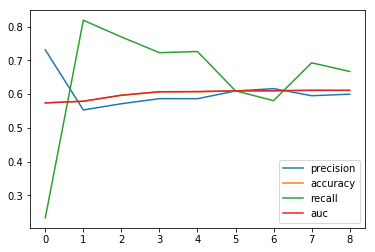

In [64]:
printScores(dtc.cv_results_, scores)

## Random Forest Classifier

In [ ]:
rfc_grid = {
    'max_depth': [2, 3, 5, 8, 10, 13, 18],
    'n_estimators': [10, 25, 50, 100]
}

### Precision, Accuracy & Recall

In [ ]:
rfc = getGSV(1, rfc_grid, scores, 'auc', 3)

In [ ]:
rfc.fit(X_train, Y_train)

In [ ]:
rfc.best_params_

In [ ]:
rfc.best_score_

In [ ]:
printScores(rfc.cv_results_, scores)

## Gradient Boost Classifier

In [ ]:
gbc_grid = {
    'max_depth': [2, 3, 5, 8, 10, 13, 18],
    'n_estimators': [10, 25, 50, 100]
}

### Precision, Accuracy & Recall

In [ ]:
gbc = getGSV(2, gbc_grid, scores, 'auc', 3)

In [ ]:
gbc.fit(X_train, Y_train)

In [ ]:
gbc.best_params_

In [ ]:
gbc.best_score_

In [ ]:
printScores(gbc.cv_results_, scores)

In [50]:
def run_model(classifier, x_train, y_train, random=False):
    if not random:
        model = utils.get_grid_search_cv(classifier=classifier_dict[classifier],
                                   param_grid=param_grid_dict[classifier],
                                   score_dict=score_dict,
                                   score_refit=score_refit,
                                   cv=cv)
    else:
        model = utils.get_randomized_search_cv(classifier=classifier_dict[classifier],
                                         param_grid=param_grid_dict[classifier],
                                         score_dict=score_dict,
                                         score_refit=score_refit,
                                         cv=cv,
                                         n_iter=n_iter)
    
    model.fit(x_train, y_train)
    print_scores(model.cv_results_, scores=score_dict, score_refit=score_refit)